In [ ]:
import sys
sys.path.append('/home/jihuawei2/projects/WinJob')
sys.path.append('/home/jihuawei2/projects/WinJob/dataset')

from model.aceread2.modeling_aceread2 import AceRead2ForConditionalGeneration
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLProcessor

model = AceRead2ForConditionalGeneration.from_pretrained("/home/jihuawei2/projects/WinJob/pretrained_weight/Qwen2.5-VL-3B-Instruct-AWQ")
processor = Qwen2_5_VLProcessor.from_pretrained("/home/jihuawei2/projects/WinJob/pretrained_weight/Qwen2.5-VL-3B-Instruct-AWQ")

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "/home/jihuawei2/projects/WinJob/dataset/pic1.png",
            },
            {"type": "text", "text": "How many flowers in this image?"},
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
input_ids_tmp = inputs['input_ids']
inputs = inputs.to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].unsqueeze(0)
model.to("cuda")
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

# 加入生成的答案看相关性
new_text = text + output_text[0]
inputs = processor(
    text=[new_text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to("cuda")
inputs['pixel_values'] = inputs['pixel_values'].unsqueeze(0)
outputs = model(**inputs, output_hidden_states=True)



In [ ]:
inputs['image_grid_thw']

In [ ]:
inputs['pixel_values'].shape

In [ ]:
from PIL import Image

image = Image.open("/home/jihuawei2/projects/WinJob/dataset/pic1.png")
image.size

In [22]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

mask = inputs['input_ids'] == 151655
image_embeddings = outputs.hidden_states[-1][0][mask[0]]

answer_embeddings = outputs.hidden_states[-1][0][input_ids_tmp.shape[1]:,:]

similarity = F.cosine_similarity(
    image_embeddings.unsqueeze(1),  # [5, 1, 512]
    answer_embeddings.unsqueeze(0),  # [1, 10, 512]
    dim=-1
)
# similarity = similarity.sum(dim=1).
# sim_expanded = similarity.repeat_interleave(4)  # 每个元素复制 4 次
similarity_resize = similarity.sum(dim=1).reshape(inputs['image_grid_thw'][0][1].item()//2, inputs['image_grid_thw'][0][2].item()//2)
# similarity_resize = similarity_resize.cpu().detach().numpy()
# similarity = similarity.cpu().detach().numpy()

In [35]:
# 添加 batch 维度：变成 [1, 11, 15]
sim = similarity_resize.unsqueeze(0)

# 继续扩展维度：变成 [1, 11, 15, 1, 1, 1, 1, 1, 1]
sim = sim.view(1, 11, 15, 1, 1, 1, 1, 1, 1)

# expand 到目标形状 (1, 11, 15, 2, 2, 3, 2, 14, 14)
sim_expanded = sim.expand(-1, -1, -1, 2, 2, 3, 2, 14, 14)

sim_recover = sim_expanded.cpu().detach().numpy().transpose(0, 6, 5, 1, 3, 7, 2, 4, 8)
sim_recover = sim_recover.reshape(2, 3, 308, 420)

In [44]:
import numpy as np
# 取第一个样本 (3, 308, 420)
img_rgb = sim_recover[0]

# 归一化到 [0, 255]（每个通道单独归一化）
img_rgb_norm = np.zeros_like(img_rgb)
for i in range(3):
    ch = img_rgb[i]
    ch_norm = (ch - ch.min()) / (ch.max() - ch.min() + 1e-8)
    img_rgb_norm[i] = ch_norm * 255

# 转为 uint8 并转为 (H, W, C)
img_rgb_uint8 = img_rgb_norm.astype(np.uint8).transpose(1, 2, 0)

# 保存
image_rgb = Image.fromarray(img_rgb_uint8)
image_rgb.save("sim_rgb.png")

In [ ]:
# 画图
plt.figure(figsize=(7, 5))
plt.imshow(sim_recover[0], cmap='viridis', aspect='auto')
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Answer Token Index')
plt.ylabel('Image Embedding Index')
plt.title('Cosine Similarity between Image and Answer Embeddings')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn

# 设置随机种子以便复现
torch.manual_seed(42)

# 创建一个简单的模型
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 2)
    
    def forward(self, x):
        x = self.linear(x)
        # 直接采样
        probs = torch.softmax(x, dim=-1)
        return torch.multinomial(probs, 1)

# 创建模型和优化器
model = SimpleModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练循环
print("开始训练...")
for i in range(10):
    optimizer.zero_grad()
    
    # 输入数据
    x = torch.randn(4, 2)
    
    # 前向传播
    y = model(x)
    
    # 计算损失
    loss = y.sum()
    
    # 反向传播
    loss.backward()
    
    # 检查梯度
    print(f"第 {i+1} 次迭代:")
    print(f"线性层的梯度: {model.linear.weight.grad}")
    
    optimizer.step()

print("\n对比普通采样:")
# 使用普通的采样进行对比
x = torch.randn(4, 2)
logits = model.linear(x)
samples = torch.multinomial(torch.softmax(logits, dim=-1), 1)
print("普通采样后的结果是否有梯度:", samples.requires_grad)


In [8]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

# 加载模型和处理器
processor = AutoProcessor.from_pretrained("/home/jihuawei2/projects/AceRead/pretrain_weights/xgen-mm-phi3-mini-Instruct/siglip-so400m-patch14-384")
model = AutoModel.from_pretrained("/home/jihuawei2/projects/AceRead/pretrain_weights/xgen-mm-phi3-mini-Instruct/siglip-so400m-patch14-384")

def get_image_features(image):
    # 处理图像
    inputs = processor(images=image, return_tensors="pt")
    # 获取patch特征
    patch_features = model.vision_model(inputs.pixel_values).last_hidden_state
    # 归一化
    # patch_features = patch_features / patch_features.norm(dim=-1, keepdim=True)
    return patch_features

def get_text_features(texts):
    # 处理文本
    inputs = processor(text=texts, return_tensors="pt", padding=True)
    text_features = model.get_text_features(**inputs)
    # 归一化
    # text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# 准备文本
texts = ["cat", "person"]

# 获取特征
image_features = get_image_features(image)
text_features = get_text_features(texts)

print("图像特征形状:", image_features.shape)
print("文本特征形状:", text_features.shape)


图像特征形状: torch.Size([1, 729, 1152])
文本特征形状: torch.Size([2, 1152])


<Figure size 1500x500 with 0 Axes>

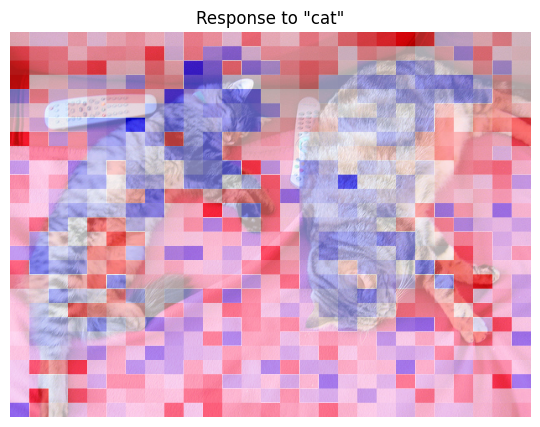

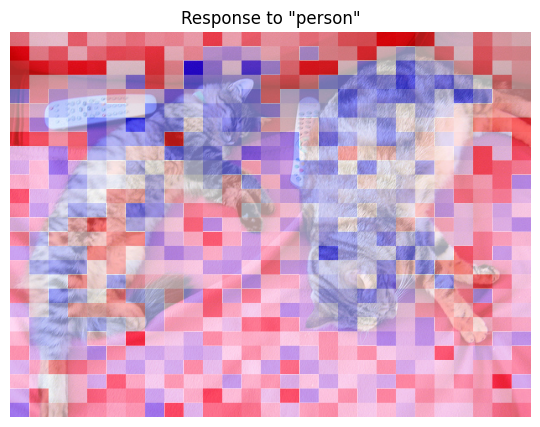

<Figure size 1500x500 with 0 Axes>

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 计算每个patch与每个文本的相似度
similarities = torch.matmul(image_features[0], text_features.T)  # [660, 3]

# 获取图像尺寸
width, height = image.size

# 计算patch的网格大小
n_patches = int(np.sqrt(similarities.shape[0]))
patch_width = width // n_patches
patch_height = height // n_patches

# 将相似度矩阵重塑为网格形状
sim_grid = similarities.reshape(n_patches, n_patches, -1)  # [h, w, 3]
# 创建连续的colormap
colors = ['blue', 'white', 'red']
cmap = LinearSegmentedColormap.from_list("custom", colors)

# 对每个文本类别分别绘制热力图
fig1 = plt.figure(figsize=(15, 5))
plt.imshow(image)
heatmap = sim_grid[:,:,0].detach().numpy()
heatmap = np.repeat(np.repeat(heatmap, patch_height, axis=0), patch_width, axis=1)
plt.imshow(heatmap, cmap=cmap, alpha=0.7)
plt.title(f'Response to "{texts[0]}"')
plt.axis('off')

fig2 = plt.figure(figsize=(15, 5))
plt.imshow(image)
heatmap = sim_grid[:,:,1].detach().numpy()
heatmap = np.repeat(np.repeat(heatmap, patch_height, axis=0), patch_width, axis=1)
plt.imshow(heatmap, cmap=cmap, alpha=0.7)
plt.title(f'Response to "{texts[1]}"')
plt.axis('off')
plt.figure(figsize=(15, 5))


In [12]:
sim_grid[:,:,0].sum()

tensor(13426.9404, grad_fn=<SumBackward0>)